# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. 7: volume of undersaturated waters with respect to aragonite 
# Fig. 7: seasonal evolution of the ice-free area in MPAs
#
# this script requires post-processed model output

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from netCDF4 import Dataset, MFDataset
import pandas as pd
from scipy.io import netcdf
from pylab import *

In [13]:
#---
# load data
#---

# path to carbonate chemistry data (names of *nc files are hard-coded in 'get_data()' function below)
path_to_data = '/global/homes/c/cnissen/ARCHIVE_Nissen2023_NatureComms_OA_in_MPAs/nc_files/'

# path to sea-ice data
path_to_data_ice = '/pscratch/sd/c/cnissen/COARZE_ice/' # script expects subfolders ssp585 (also contains hist), ssp370 etc.

# path to masks of MPAs (on original FESOM mesh)
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_7/'
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)
    
savepath2    = savepath+'eps/'
if not os.path.exists(savepath2):
    print('Created '+savepath2)
    os.makedirs(savepath2)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]
    

(72411,)


In [4]:
#---
# function to load variables
#---

def get_data(vari1,vari2,path_to_data):
    
    print ('Load ',vari1,vari2)
    
    file1 = 'Carbonate_chemistry_regional_simAssp585_1990_2100_v3.nc'
    file2 = 'Carbonate_chemistry_regional_simAssp370_2015_2100_v3.nc'
    file3 = 'Carbonate_chemistry_regional_simAssp245_2015_2100_v3.nc'
    file4 = 'Carbonate_chemistry_regional_simAssp126_2015_2100_v3.nc'
    file5 = 'Carbonate_chemistry_regional_simAssp585_1990_2100_v3.nc' 

    ff1 = Dataset(path_to_data + file1)
    ff2 = Dataset(path_to_data + file2)
    ff3 = Dataset(path_to_data + file3)
    ff4 = Dataset(path_to_data + file4)
    ff5 = Dataset(path_to_data + file5)
   
    dataA_1 = ff1.variables[vari1][:,:,:] # month x year x subregion
    dataA_2 = ff2.variables[vari1][:,:,:]
    dataA_3 = ff3.variables[vari1][:,:,:]
    dataA_4 = ff4.variables[vari1][:,:,:]
    dataA_5 = ff5.variables[vari1][:,:,:]

    dataC_1 = ff1.variables[vari2][:,:,:] # month x year x subregion
    dataC_2 = ff2.variables[vari2][:,:,:]
    dataC_3 = ff3.variables[vari2][:,:,:]
    dataC_4 = ff4.variables[vari2][:,:,:]
    dataC_5 = ff5.variables[vari2][:,:,:]

    # for ssp370, ssp245 & ssp126, add historical years to beginning of array 
    # (for these scenarios, data were only post-processed and stored in file from 2015 to 2100)
    fill_array = np.nan*np.ones([dataA_1.shape[0],25,dataA_1.shape[2]])
    dataA_2 = np.concatenate((fill_array,dataA_2),axis=1)
    dataA_3 = np.concatenate((fill_array,dataA_3),axis=1)
    dataA_4 = np.concatenate((fill_array,dataA_4),axis=1)
    dataC_2 = np.concatenate((fill_array,dataC_2),axis=1)
    dataC_3 = np.concatenate((fill_array,dataC_3),axis=1)
    dataC_4 = np.concatenate((fill_array,dataC_4),axis=1)

    ff1.close()
    ff2.close()
    ff3.close()
    ff4.close()
    ff5.close()
    
    data_all_Arag = np.stack((dataA_1,dataA_2,dataA_3,dataA_4,dataA_5),axis=3)
    data_all_Calc = np.stack((dataC_1,dataC_2,dataC_3,dataC_4,dataC_5),axis=3)
    print ('data_all_Arag.shape:',data_all_Arag.shape)
    
    return data_all_Arag,data_all_Calc


In [5]:
#---
# COLORS
#---

color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                              (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                              (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                               (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.)]

cc1 = (52./255.,103./255.,92./255.) # pine
cc2 = (161./255.,190./255.,149./255.) # sage
cc3 = (45./255.,66./255.,98./255.) # indigo
#cc4 = (77./255.,133./255.,189./255.) # blue
cc4 = (248./255.,160./255.,85./255.) # Canteloupe
cc5 = (186./255.,168./255.,150./255.) # warm grey

# Ross: 
color_list1 = [(0./255.,59./255.,70./255.),(102./255.,165./255.,173./255.),(196./255.,223./255.,230./255.)]
# eastAA: 
color_list2 = [(75./255.,116./255.,71./255.),(161./255.,190./255.,149./255.),(201./255.,209./255.,200./255.)]
# Weddell: 
color_list3 = [(26./255.,64./255.,95./255.),(51./255.,123./255.,174./255.),(208./255.,225./255.,249./255.)]
# Orkney: 
color_list4 = [(164./255.,56./255.,32./255.),(238./255.,105./255.,36./255.),(248./255.,160./255.,85./255.)]
# WAP: 
color_list5 = [(80./255.,49./255.,47./255.),(186./255.,168./255.,150./255.),(230./255.,204./255.,181./255.)]
# others
color_list6 = [(0./255.,0./255.,0./255.),(75./255.,75./255.,75./255.),(150./255.,150./255.,150./255.)]

color1 = color_list[7] # darkred
color2 = color_list[6] # pink
color5 = color_list[5] # 5=yellow, 2=green
color3 = color_list[1] # light blue
color4 = color_list[0] # dark blue

color_list = [(160./255.,24./255.,19./255.),(233./255.,76./255.,31./255.),\
                  (253./255.,154./255.,68./255.),(249./255.,213./255.,118./255.)]


Process  top50
Load  omegaA_vol_below1_top50 omegaC_vol_below1_top50
data_all_Arag.shape: (12, 111, 28, 5)
Process  RossSea_MPA


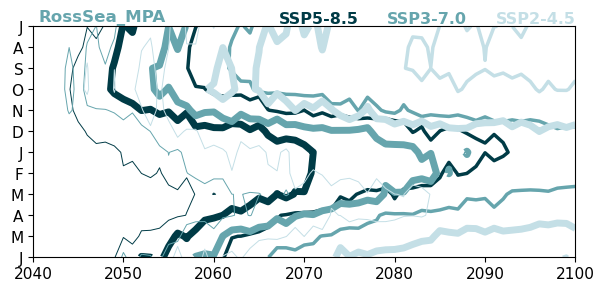

Process  WeddellSea_MPA


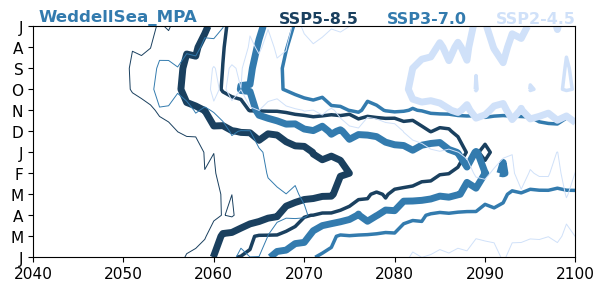

Process  Orkney_MPA


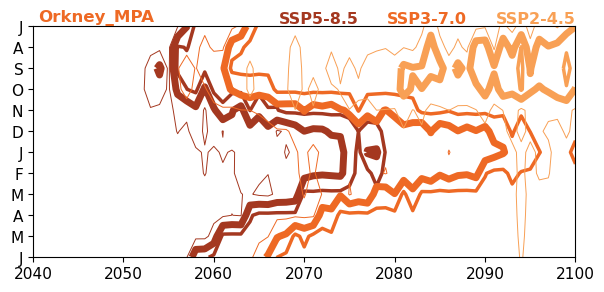

Process  AntarcticPeninsula_MPA


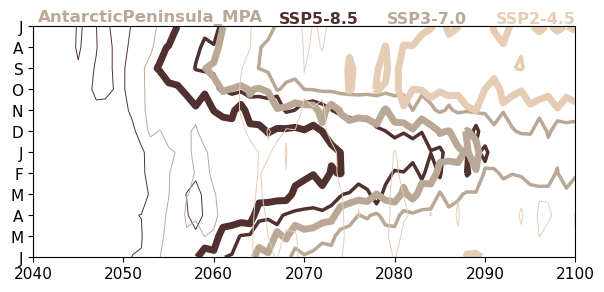

Process  East_Antarctica_all_MPA


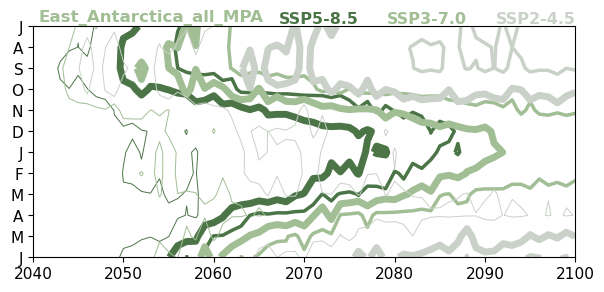

done


In [10]:
#----
# PLOT: how much volume is undersaturated? OMEGA ARAGONITE (second column in Fig. 7)
#----

save_plots = False
display_plots = True
plot_eps = False
        
depth_level_list = ['top50']#'water_column','0_10','10_100','100_500','below500']

# all subregions in file
subregions = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
             'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean']

sim_list  = ['ssp585','ssp370','ssp245']#,'ssp126']#,'simB']
sim_list2 = ['SSP5-8.5','SSP3-7.0','SSP2-4.5']

years = np.arange(1990,2100+1,1)
months = np.arange(0,12,1)

years_plot  = np.tile(years,[12,1]).transpose()
months_plot = np.tile(months,[len(years),1])

month_names = ['J','A','S','O','N','D','J','F','M','A','M','J']

fs = 11
dpicnt = 100
vv1,vv2 = 0,100
cmap1 = cm.PRGn_r #RdYlBu_r
start_year = 25+25
lw1 = 0.7
lw2 = 5
lw3 = 2.5

for dd in range(0,1):#len(depth_level_list)):
    depth_level = depth_level_list[dd] 
    print ('Process ',depth_level)
    
    vari1 = 'omegaA_vol_below1_'+depth_level
    vari2 = 'omegaC_vol_below1_'+depth_level

    # get data from file
    dataA,dataC = get_data(vari1,vari2,path_to_data)

    for rr in [8,11,14,15,19]: #range(0,len(subregions)):
        rr = subregions.index(subregions[rr])
        print ('Process ',subregions[rr])
        
        if subregions[rr] in ['RossSea_MPA']: # pine
            color_plot = cc1
            color_list = color_list1
        elif subregions[rr] in ['East_Antarctica_all_MPA']: # sage
            color_plot = cc2
            color_list = color_list2
        elif subregions[rr] in ['WeddellSea_MPA']: # indigo
            color_plot = cc3
            color_list = color_list3
        elif subregions[rr] in ['Orkney_MPA']: # blue
            color_plot = cc4
            color_list = color_list4
        elif subregions[rr] in ['AntarcticPeninsula_MPA']: # warm grey
            color_plot = cc5
            color_list = color_list5
        else:
            color_plot = 'k'
            color_list = color_list6
            
        fig7= plt.figure(num=18, figsize=(7,3), dpi=dpicnt, facecolor='w', edgecolor='k')
                
        for ss in range(0,len(sim_list)):
            #print 'Process ',sim_list[ss]
            
            dataA_plot = dataA[:,:,rr,ss]
            #print dataA_plot.shape
            
            # swap order of months
            a1 = np.zeros_like(dataA_plot)
            a1[0:6,:] = dataA_plot[6:,:]
            a1[6:,:]  = dataA_plot[0:6,:]
            dataA_plot = a1
            del a1
            
            alpha_list = [1,0.55,0.3,0.1]
            alpha1 = alpha_list[ss]
            plt.contour(years_plot[start_year:,:],months_plot[start_year:,:],\
                        dataA_plot.transpose()[start_year:,:],\
                            [10,50,90],colors=[color_list[ss],color_list[ss],color_list[ss]],\
                        linewidths = [lw1,lw2,lw3],linestyles=['-','-','-'])#,alpha=alpha1)
            
            del dataA_plot
            
        plt.xticks([2040,2050,2060,2070,2080,2090,2100],[2040,2050,2060,2070,2080,2090,2100],fontsize=fs) 
        plt.yticks(np.arange(0,12,1),month_names,fontsize=fs)
        plt.gca().invert_yaxis()
        plt.annotate(subregions[rr],xy=(0.01,1.02), xycoords='axes fraction',\
                                             ha='left',fontsize=fs+1,color=color_list[1],fontweight='bold')
        #plt.annotate(subregions[rr]+', '+depth_level,xy=(0.01,1.02), xycoords='axes fraction',\
        #                                     ha='left',fontsize=fs,color=color_list[1],fontweight='bold')
        plt.annotate(sim_list2[0],xy=(0.60,1.01), xycoords='axes fraction',\
                                             ha='right',fontsize=fs+0.5,color=color_list[0],fontweight='bold')
        plt.annotate(sim_list2[1],xy=(0.80,1.01), xycoords='axes fraction',\
                                             ha='right',fontsize=fs+0.5,color=color_list[1],fontweight='bold')
        plt.annotate(sim_list2[2],xy=(1.0,1.01), xycoords='axes fraction',\
                                             ha='right',fontsize=fs+0.5,color=color_list[2],fontweight='bold')
        if save_plots:
            filename = 'Hovmoller_volume_omega_arag_saturation_classes_all_SIM_'+\
                        subregions[rr]+'_'+depth_level+'_v2.png'
            plt.savefig(savepath1+filename,dpi = dpicnt, bbox_inches='tight')
            del filename

        if display_plots:
            plt.show()
        else:
            plt.close(fig7)
            
            
        #---
        # eps
        #---
        
        if plot_eps:
            fig7= plt.figure(num=18, figsize=(7,3), dpi=dpicnt, facecolor='w', edgecolor='k')

            for ss in range(0,len(sim_list)):

                dataA_plot = dataA[:,:,rr,ss]

                # swap order of months
                a1 = np.zeros_like(dataA_plot)
                a1[0:6,:] = dataA_plot[6:,:]
                a1[6:,:]  = dataA_plot[0:6,:]
                dataA_plot = a1
                del a1

                plt.contour(years_plot[start_year:,:],months_plot[start_year:,:],\
                            dataA_plot.transpose()[start_year:,:],\
                                [10,50,90],colors=[color_list[ss],color_list[ss],color_list[ss]],\
                            linewidths = [lw1,lw2,lw3],linestyles=['-','-','-'])

                del dataA_plot

            plt.xticks([2040,2050,2060,2070,2080,2090,2100],[],fontsize=fs) 
            plt.yticks(np.arange(0,12,1),[],fontsize=fs)
            plt.gca().invert_yaxis()
            if save_plots:
                filename = 'Hovmoller_volume_omega_arag_saturation_classes_all_SIM_'+\
                            subregions[rr]+'_'+depth_level+'_v2.eps'
                plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
                del filename

            if display_plots:
                plt.show()
            else:
                plt.close(fig7)
                  
                
print ('done')


In [ ]:
#---
# sea ice
#---

In [12]:
#----
# get masks for MPAs (on original FEOSM mesh)
#----

f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
mask_WAP_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
mask_Orkney_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
mask_RossSea_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
f1.close()


In [26]:
#---
# load data: get avg ice-free area for each region
#---
from tqdm import tqdm

sim_list = ['simAssp585','simAssp370','simAssp245','simAssp126']

# list of subareas for which to get avg sea ice cover
subregions = ['RossSea_MPA','WeddellSea_MPA','Orkney_MPA','AntarcticPeninsula_MPA','East_Antarctica_all_MPA']

years = np.arange(1990,2100+1,1)

icefree  = np.zeros([len(years),12,len(subregions),len(sim_list)])
area_reg = np.zeros(len(subregions))
# loop over years & simulations
for ss in range(0,len(sim_list)):
    print('Load ',sim_list[ss])
    if sim_list[ss] in ['simAssp585']:
        path = path_to_data_ice+'simAssp585/'
        ind_start = 0
    elif sim_list[ss] in ['simAssp370']:
        path = path_to_data_ice+'simAssp370/'
        ind_start = 2015-years[0]   
    elif sim_list[ss] in ['simAssp245']:
        path = path_to_data_ice+'simAssp245/'
        ind_start = 2015-years[0]   
    elif sim_list[ss] in ['simAssp126']:
        path = path_to_data_ice+'simAssp126/'
        ind_start = 2015-years[0]    
    
    for yy in tqdm(range(ind_start,len(years))):
            
        f2 = Dataset(path+'sic_fesom_'+str(years[yy])+'0101.nc')  
        data2 = f2.variables['sic'][:,:]
        f2.close()
        
        for rr in range(0,len(subregions)):
            if subregions[rr] in ['RossSea_MPA']:
                ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['RossSea_MPA_shelf']:
                ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['RossSea_MPA_openOcean']:
                ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['WeddellSea_MPA']:
                ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['WeddellSea_MPA_shelf']:
                ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['WeddellSea_MPA_openOcean']:
                ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['AntarcticPeninsula_MPA']:
                ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['AntarcticPeninsula_MPA_shelf']:
                ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['AntarcticPeninsula_openOcean']:
                ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['Orkney_MPA']:
                ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['Orkney_MPA_shelf']:
                ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['Orkney_MPA_openOcean']:
                ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['East_Antarctica_1_MPA']:
                ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['East_Antarctica_1_MPA_shelf']:
                ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['East_Antarctica_1_MPA_openOcean']:
                ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['East_Antarctica_2_MPA']:
                ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['East_Antarctica_2_MPA_shelf']:
                ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['East_Antarctica_2_MPA_openOcean']:
                ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['East_Antarctica_3_MPA']:
                ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0))[0]
            elif subregions[rr] in ['East_Antarctica_3_MPA_shelf']:
                ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['East_Antarctica_3_MPA_openOcean']:
                ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (mesh.topo>2000))[0]
            elif subregions[rr] in ['East_Antarctica_all_MPA']:
                ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0))[0]
            elif subregions[rr] in ['East_Antarctica_all_MPA_shelf']:
                ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (mesh.topo<=2000))[0]
            elif subregions[rr] in ['East_Antarctica_all_MPA_openOcean']:
                ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (mesh.topo>2000))[0]
            
            area_reg[rr] = np.sum(area[ind_regions])
            
            for mm in range(0,12):

                #----
                # ice-free area
                #----
                # regional avg
                data2b = data2[mm,:]
                # ice-free area in %
                data2b = 1-data2b[ind_regions]
                icefree[yy,mm,rr,ss] = 100*np.sum(data2b*area[ind_regions])/np.sum(area[ind_regions])
                del data2b
            del ind_regions
        del data2
        

Load  simAssp585


100%|██████████| 111/111 [00:01<00:00, 105.61it/s]


Load  simAssp370


100%|██████████| 86/86 [00:00<00:00, 102.30it/s]


Load  simAssp245


100%|██████████| 86/86 [00:00<00:00, 107.94it/s]


Load  simAssp126


100%|██████████| 86/86 [00:00<00:00, 110.16it/s]


In [27]:
print(subregions)

['RossSea_MPA', 'WeddellSea_MPA', 'Orkney_MPA', 'AntarcticPeninsula_MPA', 'East_Antarctica_all_MPA']


Process  RossSea_MPA


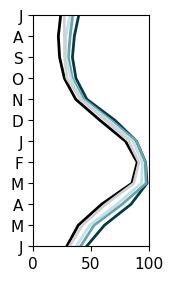

Process  WeddellSea_MPA


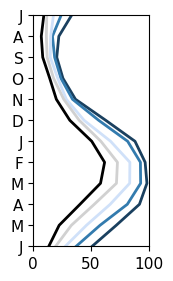

Process  Orkney_MPA


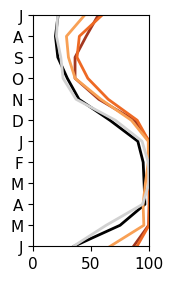

Process  AntarcticPeninsula_MPA


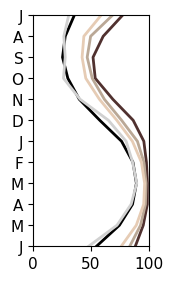

Process  East_Antarctica_all_MPA


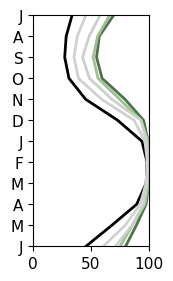

In [29]:
#----
# PLOT avg ice-free area (third column in Fig. 7
#----

save_plots = False
display_plots = True
plot_eps = False
    
lw = 2
        
for rr in range(0,len(subregions)):
    rr = subregions.index(subregions[rr])
    print ('Process ',subregions[rr])
        
    if subregions[rr] in ['RossSea_MPA']: # pine
        color_list = color_list1
    elif subregions[rr] in ['East_Antarctica_all_MPA']: # sage
        color_list = color_list2
    elif subregions[rr] in ['WeddellSea_MPA']: # indigo
        color_list = color_list3
    elif subregions[rr] in ['Orkney_MPA']: # blue
        color_list = color_list4
    elif subregions[rr] in ['AntarcticPeninsula_MPA']: # warm grey
        color_list = color_list5
    else:
        color_list = color_list6
            
    #---
    # png
    #---
    # 7,3: size of Hovmoller
    fig7= plt.figure(num=18, figsize=(1.5,3), dpi=dpicnt, facecolor='w', edgecolor='k')
        
    # get avg for 1990s
    data1 = np.mean(icefree[0:9+1,:,rr,0],axis=0)
    # swap order of months
    a1 = np.zeros_like(data1)
    a1[0:6] = data1[6:]
    a1[6:]  = data1[0:6]
    data1 = a1
    del a1
         
    plt.plot(data1,range(0,12),color='k',linewidth=lw)
        
        
    for ss in range(0,4):#len(sim_list)):
        #print 'Process ',sim_list[ss]
            
        # get avg for 2090s
        data3 = np.mean(icefree[100:109+1,:,rr,ss],axis=0)
            
        # swap order of months
        a1 = np.zeros_like(data3)
        a1[0:6] = data3[6:]
        a1[6:]  = data3[0:6]
        data3 = a1
        del a1

        #----
        # PLOT: png
        #----
        
        if ss==3: # ssp126
            plt.plot(data3,range(0,12),color=(0.82,0.82,0.82),linewidth=lw)
        else:
            plt.plot(data3,range(0,12),color=color_list[ss],linewidth=lw)
        
    plt.yticks(np.arange(0,12,1),month_names,fontsize=fs)
    plt.xticks([0,50,100],[0,50,100],fontsize=fs)
    plt.xlim((0,100))
    plt.ylim((0,11))
    plt.gca().invert_yaxis()
    if save_plots:
        filename = 'Ice_free_area_in_percent_'+\
                                sim_list[ss]+'_'+subregions[rr]+'_v2.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename

    if display_plots:
        plt.show()
    else:
        plt.close(fig7)
        
    if plot_eps:
        #---
        # eps
        #---
        # 7,3: size of Hovmoller
        fig7= plt.figure(num=18, figsize=(1.5,3), dpi=dpicnt, facecolor='w', edgecolor='k')

        # get avg for 1990s
        data1 = np.mean(icefree[0:9+1,:,rr,0],axis=0)
        # swap order of months
        a1 = np.zeros_like(data1)
        a1[0:6] = data1[6:]
        a1[6:]  = data1[0:6]
        data1 = a1
        del a1

        plt.plot(data1,range(0,12),color='k',linewidth=lw)


        for ss in range(0,4):#len(sim_list)):

            # get avg for 2090s
            data3 = np.mean(icefree[100:109+1,:,rr,ss],axis=0)

            # swap order of months
            a1 = np.zeros_like(data3)
            a1[0:6] = data3[6:]
            a1[6:]  = data3[0:6]
            data3 = a1
            del a1

            #----
            # PLOT: png
            #----

            if ss==3: # ssp126
                plt.plot(data3,range(0,12),color=(0.82,0.82,0.82),linewidth=lw)
            else:
                plt.plot(data3,range(0,12),color=color_list[ss],linewidth=lw)

        plt.yticks(np.arange(0,12,1),[],fontsize=fs)
        plt.xticks([0,50,100],[],fontsize=fs)
        plt.xlim((0,100))
        plt.ylim((0,11))
        plt.gca().invert_yaxis()
        if save_plots:
            filename = 'Ice_free_area_in_percent_'+\
                                    sim_list[ss]+'_'+subregions[rr]+'_v2.eps'
            plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename

        if display_plots:
            plt.show()
        else:
            plt.close(fig7)

        

In [24]:
print (savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_7/
